In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
#from tensorflow.keras.layers import Conv2D, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import random
from sklearn.model_selection import GridSearchCV
import tensorflow as tf
from sklearn.linear_model import LogisticRegression
import numpy as np
import pandas as pd
from sklearn.neural_network import MLPClassifier
from fancyimpute import IterativeImputer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import precision_score, recall_score,f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from tensorflow.python.framework import ops
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.preprocessing import StandardScaler
ops.reset_default_graph()
from xgboost import XGBClassifier
random.seed(271828)
np.random.seed(271828)
#import tensorflow as tf
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
tf.random.set_seed(271828)

In [5]:

def PCL_calculator(df):

    symptomatic_cutoff = 2

    intrusion = ['q6.1_INTRU', 'q6.2_DREAM', 'q6.3_FLASH', 'q6.4_UPSET', 'q6.5_PHYS']
    avoidance = ['q6.6_AVTHT', 'q6.7_AVSIT', 'q6.8_AMNES', 'q6.9_DISINT', 'q6.10_DTACH',
                 'q6.11_NUMB', 'q6.12_FUTRE']
    tred = ['q6.1_INTRU', 'q6.2_DREAM', 'q6.3_FLASH']
    only_avoidance = ['q6.6_AVTHT', 'q6.7_AVSIT', 'q6.8_AMNES']

    hypertension = ['q6.13_SLEEP', 'q6.14_ANGER', 'q6.15_CONC', 'q6.16_HYPER', 'q6.17_STRTL']

    depression = ['q6.9_DISINT', 'q6.10_DTACH', 'q6.11_NUMB', 'q6.12_FUTRE']

    df[intrusion + avoidance + hypertension].fillna(df[intrusion + avoidance + hypertension].mean(axis=1))
    intrusion_cuoff = 1
    avoidance_cuoff = 3
    hypertension_cuoff = 2
    only_avoidance_cutoff = 1
    depression_cutoff = 2
    tred_cutoff = 1

    df['sum'] = (df[intrusion + avoidance + hypertension]).sum(axis=1)

    df['intrusion'] = (df[intrusion] > symptomatic_cutoff).sum(axis=1)
    df['intrusion_cutoff'] = (df['intrusion'] >= intrusion_cuoff).astype(int)

    df['avoidance'] = (df[avoidance] > symptomatic_cutoff).sum(axis=1)
    df['avoidance_cutoff'] = (df['avoidance'] >= avoidance_cuoff).astype(int)

    df['depression'] = (df[depression] > symptomatic_cutoff).sum(axis=1)
    df['depression_cutoff'] = (df['depression'] >= depression_cutoff).astype(int)

    df['hypertention'] = (df[hypertension] > symptomatic_cutoff).sum(axis=1)
    df['hypertention_cutoff'] = (df['hypertention'] >= hypertension_cuoff).astype(int)

    df['tred'] = (df[tred] > symptomatic_cutoff).sum(axis=1)
    df['tred_cutoff'] = (df['tred'] >= tred_cutoff).astype(int)

    df['only_avoidance'] = (df[only_avoidance] > symptomatic_cutoff).sum(axis=1)
    df['only_avoidance_cutoff'] = (df['only_avoidance'] >= only_avoidance_cutoff).astype(int)

    df['regression_cutoff_33'] = (df['sum'] >= 33).astype(int)
    df['regression_cutoff_50'] = (df['sum'] >= 50).astype(int)
    df['diagnosis'] = ((df['hypertention_cutoff']) & (df['avoidance_cutoff']) & (df['intrusion_cutoff']) & (df['sum'] >= 50))

    return df



In [6]:
path = "C:\‏‏PycharmProjects\PTSD\Data\PTSD.xlsx"
df = pd.read_excel(path)
#combine with specifics of answers
df_pcl2 = pd.read_excel("C:\‏‏PycharmProjects\PTSD\Data\questionnaire6PCL2.xlsx")
df_pcl1 = pd.read_excel("C:\‏‏PycharmProjects\PTSD\Data\questionnaire6PCL1.xlsx")
df = df.merge(df_pcl1, on="ID", how='outer')
df = df.merge(df_pcl2, suffixes=('_pcl1', '_pcl2'), on="ID", how='outer')

df_pcl3 = pd.read_excel("C:\‏‏PycharmProjects\PTSD\Data\questionnaire6PCL3.xlsx")
df_pcl3 = PCL_calculator(df_pcl3)
df = df.merge(df_pcl3.drop(['PCL3_Strict', 'pcl3', 'PCL3_Broad'], axis=1), on="ID", how='outer')
# rmoving missing Y's
df = df[~df['PCL_Strict3'].isna()]

## features 

In [7]:

features = ["age", "highschool_diploma", "dyslexia", "ADHD", "T1Acc1t", "T1Acc1n", "T1bias", "phq1", "lot1",
                "trait1",
                "state1", "PCL1", "PCL_Broad1", "PCL_Strict1", "phq2", "lot2", "trait2", "state2", "PCL2", "PCL_Broad2",
                "PCL_Strict2", "cd_risc1", "active_coping1", "planning1", "positive_reframing1", "acceptance1",
                "humor1",
                "religion1", "emotional_support1", "instrumental_support1", "self_distraction1", "denial1",
                "venting1", "substance_use1", "behavioral_disengagement1", "self_blame1", "active_coping2", "planning2",
                "positive_reframing2", "acceptance2", "humor2", "religion2", "emotional_support2",
                "instrumental_support2",
                "self_distraction2", "denial2", "venting2", "substance_use2", "behavioral_disengagement2",
                "self_blame2",
                "trauma_history8_1", "HML_5HTT", "HL_MAOA", "HML_NPY", "COMT_Hap1_recode",
                "COMT_Hap2_recode", "COMT_Hap1_LvsMH", "HML_FKBP5", 'q6.1_INTRU_pcl1', 
                'q6.2_DREAM_pcl1', 'q6.3_FLASH_pcl1', 'q6.4_UPSET_pcl1',
                  'q6.5_PHYS_pcl1', 'q6.6_AVTHT_pcl1', 'q6.7_AVSIT_pcl1', 'q6.8_AMNES_pcl1', 'q6.9_DISINT_pcl1',
                  'q6.10_DTACH_pcl1', 'q6.11_NUMB_pcl1', 'q6.12_FUTRE_pcl1', 'q6.13_SLEEP_pcl1',
                  'q6.14_ANGER_pcl1', 'q6.15_CONC_pcl1', 'q6.16_HYPER_pcl1', 'q6.17_STRTL_pcl1',
                  'q6.1_INTRU_pcl2', 'q6.2_DREAM_pcl2', 'q6.3_FLASH_pcl2', 'q6.4_UPSET_pcl2',
                  'q6.5_PHYS_pcl2', 'q6.6_AVTHT_pcl2', 'q6.7_AVSIT_pcl2', 'q6.8_AMNES_pcl2', 'q6.9_DISINT_pcl2',
                  'q6.10_DTACH_pcl2', 'q6.11_NUMB_pcl2', 'q6.12_FUTRE_pcl2', 'q6.13_SLEEP_pcl2',
                  'q6.14_ANGER_pcl2', 'q6.15_CONC_pcl2', 'q6.16_HYPER_pcl2', 'q6.17_STRTL_pcl2']

In [8]:
discrete_features = ["age", "highschool_diploma", "dyslexia", "ADHD", "phq1", "lot1",
                    "trait1", "state1", "PCL1", "PCL_Broad1", "PCL_Strict1", "phq2", "lot2",
                    "trait2", "state2", "PCL2", "PCL_Broad2", "PCL_Strict2", "cd_risc1", "active_coping1",
                    "planning1", "positive_reframing1", "acceptance1", "humor1", "religion1",
                    "emotional_support1", "instrumental_support1", "self_distraction1", "denial1",
                    "venting1", "substance_use1", "behavioral_disengagement1", "self_blame1", "active_coping2",
                    "planning2", "positive_reframing2", "acceptance2", "humor2", "religion2", "emotional_support2",
                    "instrumental_support2", "self_distraction2", "denial2", "venting2", "substance_use2",
                    "behavioral_disengagement2", "self_blame2", "trauma_history8_1",
                    'q6.1_INTRU_pcl1', 'q6.2_DREAM_pcl1', 'q6.3_FLASH_pcl1', 'q6.4_UPSET_pcl1',
                    'q6.5_PHYS_pcl1', 'q6.6_AVTHT_pcl1', 'q6.7_AVSIT_pcl1', 'q6.8_AMNES_pcl1', 'q6.9_DISINT_pcl1',
                    'q6.10_DTACH_pcl1', 'q6.11_NUMB_pcl1', 'q6.12_FUTRE_pcl1', 'q6.13_SLEEP_pcl1',
                    'q6.14_ANGER_pcl1', 'q6.15_CONC_pcl1', 'q6.16_HYPER_pcl1', 'q6.17_STRTL_pcl1',
                    'q6.1_INTRU_pcl2', 'q6.2_DREAM_pcl2', 'q6.3_FLASH_pcl2', 'q6.4_UPSET_pcl2',
                    'q6.5_PHYS_pcl2', 'q6.6_AVTHT_pcl2', 'q6.7_AVSIT_pcl2', 'q6.8_AMNES_pcl2', 'q6.9_DISINT_pcl2',
                    'q6.10_DTACH_pcl2', 'q6.11_NUMB_pcl2', 'q6.12_FUTRE_pcl2', 'q6.13_SLEEP_pcl2',
                    'q6.14_ANGER_pcl2', 'q6.15_CONC_pcl2', 'q6.16_HYPER_pcl2', 'q6.17_STRTL_pcl2',
                    'intrusion_cutoff', 'avoidance_cutoff', 'hypertention_cutoff', 'regression_cutoff_50',
                    'regression_cutoff_33', 'only_avoidance_cutoff', 'tred_cutoff', 'depression_cutoff']

In [9]:
genome_features = ["HML_5HTT", "HL_MAOA", "HML_NPY", "COMT_Hap1_recode",
                "COMT_Hap2_recode", "COMT_Hap1_LvsMH", "HML_FKBP5"]
continuous_features = ["T1Acc1t", "T1Acc1n", "T1bias"]

## fill the missing values

In [10]:
df[genome_features] = df[genome_features].fillna(0)
df[continuous_features] = df[continuous_features].fillna(df[continuous_features].mean())
df[discrete_features] = df[discrete_features].fillna(df[discrete_features].median())


## cut off the test set

In [11]:
X, X_out, Y, y_out = train_test_split(df[features], df[['intrusion_cutoff', 'avoidance_cutoff', 'hypertention_cutoff', 'regression_cutoff_50',
                    'regression_cutoff_33', 'only_avoidance_cutoff', 'tred_cutoff', 'depression_cutoff', 'PCL_Strict3']],
                                      test_size=0.25, random_state=271828, stratify=df['PCL_Strict3'])

## the Model

In [12]:
model = Pipeline(steps=[
    
    ('anova', SelectKBest()),
    ('clf',  XGBClassifier(random_state=271828))])

grid_params = [{'anova__k':[40],
                'clf__n_estimators': [1000],  'clf__max_depth': [1],
               'clf__learning_rate': [0.01], 'clf__pos_class_weight':[0.5]}]


## intrusion

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, Y['intrusion_cutoff'], test_size=0.25, stratify=Y['PCL_Strict3'], random_state=271828)
cv = StratifiedKFold(10, random_state=271828)  

In [14]:
intrusion_gs = GridSearchCV(model, grid_params,  scoring="roc_auc", cv=cv)
intrusion_gs.fit(X_train, y_train)
print("roc_auc", intrusion_gs.best_score_,"\nparams = ", intrusion_gs.best_params_)

roc_auc 0.772737840479776 
params =  {'anova__k': 40, 'clf__learning_rate': 0.01, 'clf__max_depth': 1, 'clf__n_estimators': 1000, 'clf__pos_class_weight': 0.5}


In [15]:
scores = cross_val_score(intrusion_gs.best_estimator_, X_train, y_train, scoring="precision", cv=cv)
print("precision\n", scores,"\nmean = ", scores.mean())


precision
 [1.         0.4        0.8        1.         0.5        0.2
 0.66666667 0.66666667 0.85714286 0.6       ] 
mean =  0.669047619047619


## avoidance cutoff

In [16]:
model = Pipeline(steps=[
    
    ('anova', SelectKBest()),
    ('clf',  XGBClassifier(random_state=271828))])

grid_params = [{'anova__k':[10],
                'clf__n_estimators': [600],  'clf__max_depth': [2],
               'clf__learning_rate': [0.01], 'clf__pos_class_weight':[0.5]}]


In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, Y['avoidance_cutoff'], test_size=0.25, stratify=Y['PCL_Strict3'], random_state=271828)
cv = StratifiedKFold(10, random_state=271828)  

In [18]:
avoidance_gs = GridSearchCV(model, grid_params,  scoring="roc_auc", cv=cv)
avoidance_gs.fit(X_train, y_train)
print("roc_auc", avoidance_gs.best_score_,"\nparams = ", avoidance_gs.best_params_)

roc_auc 0.7878719055189645 
params =  {'anova__k': 10, 'clf__learning_rate': 0.01, 'clf__max_depth': 2, 'clf__n_estimators': 600, 'clf__pos_class_weight': 0.5}


In [19]:
scores = cross_val_score(avoidance_gs.best_estimator_, X_train, y_train, scoring="precision", cv=cv)
print("precision\n", scores,"\nmean = ", scores.mean())


precision
 [0.         0.5        0.         0.         0.         0.
 0.33333333 0.         0.2        0.5       ] 
mean =  0.15333333333333332


## hypertension cutoff

In [20]:
model = Pipeline(steps=[
    
    ('anova', SelectKBest()),
    ('clf',  XGBClassifier(random_state=271828))])

grid_params = [{'anova__score_func':[f_classif], 'anova__k':[5],
                'clf__n_estimators': [600],  'clf__max_depth': [6],
               'clf__learning_rate': [0.01], 'clf__pos_class_weight':[0.5]}]


In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, Y['hypertention_cutoff'], test_size=0.25, stratify=Y['PCL_Strict3'], random_state=271828)
cv = StratifiedKFold(10, random_state=271828)  

In [22]:
hypertention_gs = GridSearchCV(model, grid_params,  scoring="roc_auc", cv=cv)
hypertention_gs.fit(X_train, y_train)
print("roc_auc", hypertention_gs.best_score_,"\nparams = ", hypertention_gs.best_params_)

roc_auc 0.7853030358070681 
params =  {'anova__k': 5, 'anova__score_func': <function f_classif at 0x00000211456FE158>, 'clf__learning_rate': 0.01, 'clf__max_depth': 6, 'clf__n_estimators': 600, 'clf__pos_class_weight': 0.5}


In [23]:
scores = cross_val_score(hypertention_gs.best_estimator_, X_train, y_train, scoring="precision", cv=cv)
print("precision\n", scores,"\nmean = ", scores.mean())


precision
 [0.75       0.5        0.42857143 1.         0.42857143 0.5
 1.         0.5        0.57142857 0.66666667] 
mean =  0.6345238095238096


## regression_cutoff_50

In [24]:
model = Pipeline(steps=[
    
    ('anova', SelectKBest()),
    ('clf',  XGBClassifier(random_state=271828))])

grid_params = [{'anova__k':[50],
                'clf__n_estimators': [400],  'clf__max_depth': [4],
               'clf__learning_rate': [0.1], 'clf__pos_class_weight':[0.25]}]


In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, Y['regression_cutoff_50'], test_size=0.25, stratify=Y['PCL_Strict3'], random_state=271828)
cv = StratifiedKFold(10, random_state=271828)  

In [26]:
regression_50_gs = GridSearchCV(model, grid_params,  scoring="roc_auc", cv=cv)
regression_50_gs.fit(X_train, y_train)
print("roc_auc", regression_50_gs.best_score_,"\nparams = ", regression_50_gs.best_params_)

roc_auc 0.8624642308852836 
params =  {'anova__k': 50, 'clf__learning_rate': 0.1, 'clf__max_depth': 4, 'clf__n_estimators': 400, 'clf__pos_class_weight': 0.25}


In [27]:
scores = cross_val_score(regression_50_gs.best_estimator_, X_train, y_train, scoring="precision", cv=cv)
print("precision\n", scores,"\nmean = ", scores.mean())


precision
 [0.5 0.  0.5 0.  0.  0.  0.  0.  0.  0. ] 
mean =  0.1


## regression_cutoff_33

In [28]:
model = Pipeline(steps=[
    
    ('anova', SelectKBest()),
    ('clf',  XGBClassifier(random_state=271828))])

grid_params = [{'anova__k':[50],
                'clf__n_estimators': [200],  'clf__max_depth': [3],
               'clf__learning_rate': [0.1], 'clf__pos_class_weight':[0.25]}]


In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, Y['regression_cutoff_33'], test_size=0.25, stratify=Y['PCL_Strict3'], random_state=271828)
cv = StratifiedKFold(10, random_state=271828)  

In [30]:
regression_33_gs = GridSearchCV(model, grid_params,  scoring="roc_auc", cv=cv)
regression_33_gs.fit(X_train, y_train)
print("roc_auc", regression_33_gs.best_score_,"\nparams = ", regression_33_gs.best_params_)

roc_auc 0.8603592654394795 
params =  {'anova__k': 50, 'clf__learning_rate': 0.1, 'clf__max_depth': 3, 'clf__n_estimators': 200, 'clf__pos_class_weight': 0.25}


In [31]:
scores = cross_val_score(regression_33_gs.best_estimator_, X_train, y_train, scoring="precision", cv=cv)
print("precision\n", scores,"\nmean = ", scores.mean())


precision
 [0.66666667 0.5        0.83333333 0.5        0.66666667 0.5
 0.75       0.6        0.75       0.66666667] 
mean =  0.6433333333333333


## only_avoidance_cutoff

In [32]:
model = Pipeline(steps=[
    
    ('anova', SelectKBest()),
    ('clf',  XGBClassifier(random_state=271828))])

grid_params = [{'anova__k':[3],
                'clf__n_estimators': [200],  'clf__max_depth': [3],
               'clf__learning_rate': [0.1], 'clf__pos_class_weight':[0.25]}]


In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, Y['only_avoidance_cutoff'], test_size=0.25, stratify=Y['PCL_Strict3'], random_state=271828)
cv = StratifiedKFold(10, random_state=271828)  

In [34]:
only_avoidance_gs = GridSearchCV(model, grid_params,  scoring="roc_auc", cv=cv)
only_avoidance_gs.fit(X_train, y_train)
print("roc_auc", only_avoidance_gs.best_score_,"\nparams = ", only_avoidance_gs.best_params_)

roc_auc 0.643342315922961 
params =  {'anova__k': 3, 'clf__learning_rate': 0.1, 'clf__max_depth': 3, 'clf__n_estimators': 200, 'clf__pos_class_weight': 0.25}


In [35]:
scores = cross_val_score(only_avoidance_gs.best_estimator_, X_train, y_train, scoring="precision", cv=cv)
print("precision\n", scores,"\nmean = ", scores.mean())


precision
 [0.5        0.55555556 0.         0.6        0.33333333 0.
 0.5        0.4        0.5        0.33333333] 
mean =  0.37222222222222223


## tred_cutoff

In [36]:
model = Pipeline(steps=[
    
    ('anova', SelectKBest()),
    ('clf',  XGBClassifier(random_state=271828))])

grid_params = [{'anova__k':[35, 15, 25],
                'clf__n_estimators': [600],  'clf__max_depth': [1],
               'clf__learning_rate': [0.05], 'clf__pos_class_weight':[0.25]}]


In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, Y['tred_cutoff'], test_size=0.25, stratify=Y['PCL_Strict3'], random_state=271828)
cv = StratifiedKFold(10, random_state=271828)  

In [38]:
tred_gs = GridSearchCV(model, grid_params,  scoring="roc_auc", cv=cv)
tred_gs.fit(X_train, y_train)
print("roc_auc", tred_gs.best_score_,"\nparams = ", tred_gs.best_params_)

roc_auc 0.7107667363349182 
params =  {'anova__k': 25, 'clf__learning_rate': 0.05, 'clf__max_depth': 1, 'clf__n_estimators': 600, 'clf__pos_class_weight': 0.25}


In [39]:
scores = cross_val_score(tred_gs.best_estimator_, X_train, y_train, scoring="precision", cv=cv)
print("precision\n", scores,"\nmean = ", scores.mean())


precision
 [1.         0.5        0.5        1.         0.4        0.
 0.5        0.         0.66666667 0.33333333] 
mean =  0.48999999999999994


## depression_cutoff

In [40]:
model = Pipeline(steps=[
    
    ('anova', SelectKBest()),
    ('clf',  XGBClassifier(random_state=271828))])

grid_params = [{'anova__k':[10],
                'clf__n_estimators': [100],  'clf__max_depth': [2],
               'clf__learning_rate': [0.1], 'clf__pos_class_weight':[0.25]}]


In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, Y['depression_cutoff'], test_size=0.25, stratify=Y['PCL_Strict3'], random_state=271828)
cv = StratifiedKFold(10, random_state=271828)  

In [42]:
depression_gs = GridSearchCV(model, grid_params,  scoring="roc_auc", cv=cv)
depression_gs.fit(X_train, y_train)
print("roc_auc", depression_gs.best_score_,"\nparams = ", depression_gs.best_params_)

roc_auc 0.7167282637870872 
params =  {'anova__k': 10, 'clf__learning_rate': 0.1, 'clf__max_depth': 2, 'clf__n_estimators': 100, 'clf__pos_class_weight': 0.25}


In [43]:
scores = cross_val_score(depression_gs.best_estimator_, X_train, y_train, scoring="precision", cv=cv)
print("precision\n", scores,"\nmean = ", scores.mean())


precision
 [0.75       1.         0.66666667 0.66666667 0.         0.5
 0.33333333 0.         0.6        0.5       ] 
mean =  0.5016666666666666


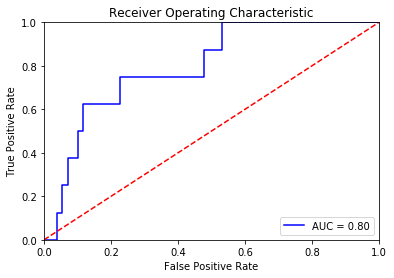

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, Y['PCL_Strict3'], test_size=0.25, stratify=Y['PCL_Strict3'], random_state=271828)

from sklearn.metrics import roc_curve, auc

y_pred_only_avoidance = only_avoidance_gs.best_estimator_.predict_proba(X_test)
y_pred_depression = depression_gs.best_estimator_.predict_proba(X_test)
y_pred_tred = tred_gs.best_estimator_.predict_proba(X_test)
y_pred_33 = regression_33_gs.best_estimator_.predict_proba(X_test)
y_pred_50 = regression_50_gs.best_estimator_.predict_proba(X_test)
y_pred_intrusion = intrusion_gs.best_estimator_.predict_proba(X_test)
y_pred_avoidance = avoidance_gs.best_estimator_.predict_proba(X_test)
y_pred_hypertension = hypertention_gs.best_estimator_.predict_proba(X_test)
preds = y_pred_50[:, 1]* y_pred_intrusion[:,1] * y_pred_avoidance[:,1] * y_pred_hypertension[:,1]

fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

[1.5735666e-06,
 3.3944848e-06,
 0.00017469712,
 0.0015909694,
 0.0039461893,
 0.012844844,
 0.02821377,
 0.05271889]

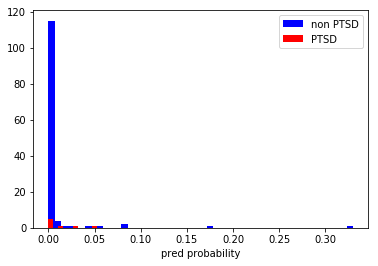

In [46]:
plt.hist(preds[y_test==0], bins=50, color="b", label="non PTSD")
plt.hist(preds[y_test==1], color="r", label="PTSD")
plt.xlabel('pred probability')
plt.legend();
sorted(preds[y_test==1])

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, stratify=Y['PCL_Strict3'], random_state=271828)
cv = StratifiedKFold(5, random_state=271828)
scores_f = []
scores_p = []
scores_r = []
scores_auc = []


for train, test in cv.split(X_train, y_train['PCL_Strict3']):
    X_train_cv = X_train.iloc[train]
    y_train_cv = y_train.iloc[train]

    t = [y_train_cv['intrusion_cutoff'], y_train_cv['avoidance_cutoff'],
         y_train_cv['hypertention_cutoff'], y_train_cv['regression_cutoff_50']]
    
    y_pred_intrusion = intrusion_gs.best_estimator_.fit(X_train_cv, t[0]).predict_proba(X_train.iloc[test])
    y_pred_avoidance = depression_gs.best_estimator_.fit(X_train_cv, t[1]).predict_proba(X_train.iloc[test])
    y_pred_hypertension = hypertention_gs.best_estimator_.fit(X_train_cv, t[2]).predict_proba(X_train.iloc[test])
    y_pred_regression_50 = regression_50_gs.best_estimator_.fit(X_train_cv, t[3]).predict_proba(X_train.iloc[test])

    y_pred = (y_pred_intrusion[:, 1] * y_pred_avoidance[:, 1] *\
              y_pred_hypertension[:, 1] * y_pred_regression_50[:, 1]) > 1.57e-06

    scores_f.append(f1_score(y_train['PCL_Strict3'].iloc[test], y_pred))
    scores_p.append(precision_score(y_train['PCL_Strict3'].iloc[test], y_pred))
    scores_r.append(recall_score(y_train['PCL_Strict3'].iloc[test], y_pred))
    scores_auc.append(roc_auc_score(y_train['PCL_Strict3'].iloc[test], y_pred))

In [52]:
print(scores_f)
print(np.mean(scores_p))
print(scores_r)
print(scores_auc)
print(np.mean(scores_auc))

[0.1851851851851852, 0.20833333333333334, 0.14285714285714285, 0.2380952380952381, 0.1851851851851852]
0.10678544202093157
[1.0, 1.0, 0.8, 1.0, 1.0]
[0.7142857142857143, 0.7532467532467533, 0.5907894736842105, 0.7894736842105263, 0.7105263157894737]
0.7116643882433357


In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, stratify=Y['PCL_Strict3'], random_state=271828)
cv = StratifiedKFold(5, random_state=271828)
scores_f = []
scores_p = []
scores_r = []
scores_auc = []


for train, test in cv.split(X_train, y_train['PCL_Strict3']):
    X_train_cv = X_train.iloc[train]
    y_train_cv = y_train.iloc[train]

    t = [y_train_cv['intrusion_cutoff'], y_train_cv['avoidance_cutoff'],
         y_train_cv['hypertention_cutoff'], y_train_cv['regression_cutoff_50']]
    
    y_pred_intrusion = intrusion_gs.best_estimator_.fit(X_train_cv, t[0]).predict_proba(X_train.iloc[test])
    y_pred_avoidance = depression_gs.best_estimator_.fit(X_train_cv, t[1]).predict_proba(X_train.iloc[test])
    y_pred_hypertension = hypertention_gs.best_estimator_.fit(X_train_cv, t[2]).predict_proba(X_train.iloc[test])
    y_pred_regression_50 = regression_50_gs.best_estimator_.fit(X_train_cv, t[3]).predict_proba(X_train.iloc[test])

    y_pred = (y_pred_intrusion[:, 1] * y_pred_avoidance[:, 1] *\
              y_pred_hypertension[:, 1] * y_pred_regression_50[:, 1]) > 0.052

    scores_f.append(f1_score(y_train['PCL_Strict3'].iloc[test], y_pred))
    scores_p.append(precision_score(y_train['PCL_Strict3'].iloc[test], y_pred))
    scores_r.append(recall_score(y_train['PCL_Strict3'].iloc[test], y_pred))
    scores_auc.append(roc_auc_score(y_train['PCL_Strict3'].iloc[test], y_pred))

In [54]:
print(scores_f)
print(np.mean(scores_p))
print(scores_r)
print(scores_auc)
print(np.mean(scores_auc))

[0.5, 0.28571428571428575, 0.0, 0.28571428571428575, 0.25]
0.39999999999999997
[0.4, 0.2, 0.0, 0.2, 0.2]
[0.6935064935064935, 0.5935064935064934, 0.4934210526315789, 0.5934210526315788, 0.5868421052631579]
0.5921394395078605
